In [1]:
# Import 
import pandas as pd 
import numpy as np
import mne
import matplotlib.pyplot as plt 
from scipy.fft import rfft, rfftfreq

# Handle sys PATH
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Internal import 
from signal_analysis.feature_extraction import *

In [2]:
# Import dataset - DREAM 
df = pd.read_csv("../dataset/DREAM/Datasets.csv", index_col=0)
rec_df = pd.read_csv("../dataset/DREAM/Data records.csv", index_col=0)
people_df = pd.read_csv("../dataset/DREAM/People.csv")

file = "../dataset/DREAM/Zhang & Wamsley 2019/Data/PSG/subject026_Morning.edf"
data = mne.io.read_raw_edf(file)
dream_df = data.get_data()

# Metadata 
info = data.info
channels = data.ch_names
raw_df = pd.DataFrame(dream_df)
raw_df.index = channels

Extracting EDF parameters from c:\Users\PC\Documents\Personal Projects\AI_Honor_track\project\TUe-Honors-MedAI\dataset\DREAM\Zhang & Wamsley 2019\Data\PSG\subject026_Morning.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
# Record info
rec_df \
    .loc[rec_df.Filename == "subject026_Morning.edf"] \
    .iloc[0];

#### 1. Multitaper spectral analysis 

Decompose the raw EEG data in DREAM dataset into spectrogram similar to the PhysioNet dataset SDB. 
1. Divide into 2s epoch - Be aware of the sampling rate
2. Appy multitaper spectral analysis to drive spectrogram of 0.5 Hz band between 0 Hz and 100 Hz for each window of 2s (epoch)

In [4]:
# Filter 
eeg_df = raw_df.loc["Fp1-REF"].copy().values
sample_df = eeg_df[:800] # Get first epoch of 2s 

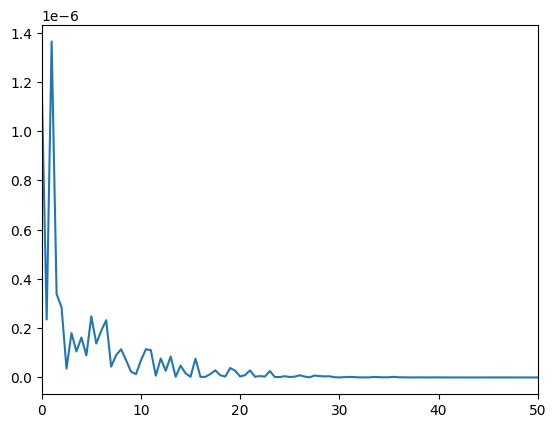

In [5]:
# Fourier Transform to frequency domain
ft_transform = FourierTransform(400, 0.5)
ft_output, freq_bin = ft_transform.transform(sample_df, 2)
y = np.square(ft_output)
plt.plot(freq_bin, y)
plt.xlim(0, 50)
plt.show()

Now we do Multitapered spectral analysis which is an improved version of the FT using the mne package. The improvements are:

In [6]:
# Import mne
from mne.time_frequency import psd_array_multitaper

    Using multitaper spectrum estimation with 7 DPSS windows


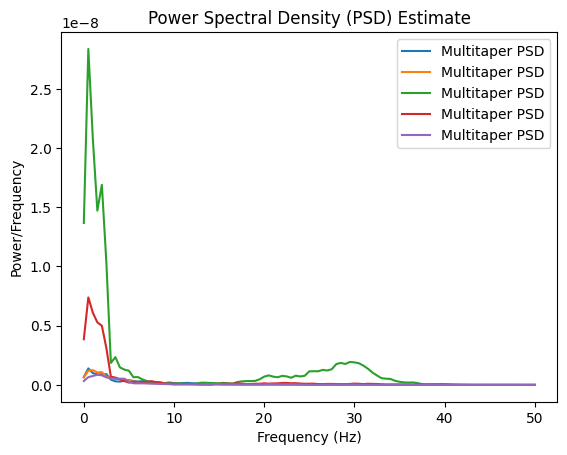

In [7]:
# Calculate power spectral density (PSD) using multitaper method (Sample)
n = len(eeg_df)
n_sample = (n // 800) * 800
X = eeg_df[:n_sample].reshape(n // 800, 800)

psds, freqs = psd_array_multitaper(X, sfreq=400, fmin=0, fmax=50, n_jobs=1, output="power")
plt.figure()
plt.plot(freqs, psds[0:5].T, label='Multitaper PSD')
plt.title('Power Spectral Density (PSD) Estimate')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency')
plt.legend()
plt.show()

In [8]:
# Define Multitaper method function 
def multitaper_spectral_analysis(sample, fs=400, fmin=0, fmax=50, epoch_size=2, f_res=0.5):
    n = len(sample)
    n_per_epoch = epoch_size * fs 
    n_epoch = (n // n_per_epoch)
    X = sample[:n_epoch * n_per_epoch].reshape(n // n_per_epoch, n_per_epoch)

    psds, freqs = psd_array_multitaper(X, fs, fmin=fmin, fmax=fmax, n_jobs=1, output="power")

    return psds, freqs

    
psds, freqs = multitaper_spectral_analysis(eeg_df)

    Using multitaper spectrum estimation with 7 DPSS windows


In [9]:
# Similar with Multitaper class 
transformer = MultitaperSpectralTransform()
psds, freqs = transformer.transform(eeg_df)

    Using multitaper spectrum estimation with 7 DPSS windows


#### 2. BWP - Banwise power in canonical spectral ranges 

In [10]:
# Example 
BP_tranform = BandwisePowerTransform()

# For raw psds
BP_tranform.transform(psds, freqs).shape

(5, 36)

In [11]:
# For MST object
BP_tranform.transform(transformer).shape

(5, 36)

In [12]:
# For FT object 
BP_tranform.transform(ft_transform).shape

(5, 1)

#### 3. PCA 

In [13]:
# Import PCA 
from sklearn.decomposition import PCA 

In [16]:
# Example 
pca_transform = PCATransform(n_components=3)
pca_transform.transform(transformer).shape # Transformer here is a MultitaperSpectralTransform object

(36, 3)